In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

# 4.1 Clustering & 4.2 A clustering objective

- given N n-vectors $x_1, \ldots ,x_N$
- goal: partition (divide, cluster) into k groups
- want vectors in the same group to be close to one another

The goal of grouping is to partition (divide, cluster) N n-vectors into k groups, and the vectors in each group are close to each other.

## Clustering objective
- $G_j \subset {1, \ldots ,N}$ is group $j$, for $j = 1, \ldots ,k$
- $c_i$ is group that $x_i$ is in: $i \in G_{c_i}$
- group *representatives*: n-vectors $z_1, \ldots ,z_k$
- clustering objective function is
$$
J^{clust} =\frac{1}{N} \sum^{N}_{i=1} \left\| x_i − z_{c_i} \right\| ^2
$$
mean square distance from vectors to associated representative
-  $J^{clust}$ small means good clustering
- **goal**: choose clustering $c_i$ and representatives $z_j$ to minimize $J^{clust}$

"Objective (function)" is used to quantify the "goodness" of "choice of clustering", and can be used for other optimization problems.

## Partitioning the vectors given the representatives
- suppose representatives $z_1,\ldots ,z_k$ are given
- how do we assign the vectors to groups, i.e., choose $c_1,\ldots,c_N$?
- $c_i$ only appears in term $\left\|x_i − z_{c_i}\right\|^2$ in $J^{clust}$
- to minimize over $c_i$, choose $c_i$ so $\left\|x_i − z_{c_i}\right\|^2 = \mathop {\min}\limits_j \left\|x_i − z_j\right\|^2$
- i.e., assign each vector to its nearest representative

## Choosing representatives given the partition
- given the partition $G_1, \ldots ,G_k$, how do we choose representatives $z_1, \ldots ,z_k$ to minimize $J^{clust}$?
- $J^{clust}$ splits into a sum of k sums, one for each $z_j$:
$$
J^{clust} = J_1 + \ldots + J_k, \quad J_j = (1/N) \sum_{i\in G_j} \left\| x_i − z_{jk} \right\| ^2
$$
- so we choose $z_j$ to minimize mean square distance to the points in its partition
- this is the mean (or average or centroid) of the points in the partition:
$$
z_j = (1/|G_j|)  \sum_{i\in G_j}{x_i}
$$

# 4.3 The k-means algorithm

alternate between updating the partition, then the representatives

**given** $x_1,\ldots ,x_N \in R^n$ and $z_1,\ldots ,z_k \in R^n$

**repeat**

Update partition: assign $i$ to $G_j, \  j = \mathop {argmin}\limits_j' \left\|x_i − z_{j'} \right\|^2$

Update centroids: $z_j = \frac{1}{|G_j|} \sum_{i \in G_j} x_i$

**until** $z_1,\ldots ,z_k$ stop changing

## Convergence of k-means algorithm
- $J^{clust}$ goes down in each step, until the $z_j$’s stop changing
- but (in general) the k-means algorithm does not find the partition that minimizes $J^{clust}$
- k-means is a heuristic: it is not guaranteed to find the smallest possible value of $J^{clust}$
- the final partition (and its value of $J^{clust}$) can depend on the initial representatives
- common approach:
    - run k-means 10 times, with different (often random) initial representatives
    - take as final partition the one with the smallest value of $J^{clust}$

## Group assignment

```julia
function kmeans(x, k; maxiters = 100, tol = 1e-5)

    N = length(x)
    n = length(x[1])
    distances = zeros(N) # used to store the distance of each
    # point to the nearest representative.
    reps = [zeros(n) for j=1:k] # used to store representatives.

    # ’assignment’ is an array of N integers between 1 and k.
    # The initial assignment is chosen randomly.
    assignment = [ rand(1:k) for i in 1:N ]
    
    Jprevious = Inf # used in stopping condition
    for iter = 1:maxiters

        # Cluster j representative is average of points in cluster j.
        for j = 1:k
            group = [i for i=1:N if assignment[i] == j]
            reps[j] = sum(x[group]) / length(group);
        end;

        # For each x[i], find distance to the nearest representative
        # and its group index.
        for i = 1:N
            (distances[i], assignment[i]) =
            findmin([norm(x[i] - reps[j]) for j = 1:k])
        end;

        # Compute clustering objective.
        J = norm(distances)^2 / N

        # Show progress and terminate if J stopped decreasing.
        println("Iteration ", iter, ": Jclust = ", J, ".")
        if iter > 1 && abs(J - Jprevious) < tol * J
            return assignment, reps
        end
        Jprevious = J
    end

end
```

Create synthetic data

In [2]:
X = np.concatenate(
    [[.3*np.random.randn(2) for i in range(100)],
     [np.array([1,1]) + .3*np.random.randn(2) for i in range(100)],
     [np.array([1,-1]) + .3*np.random.randn(2) for i in range(100)]]
)

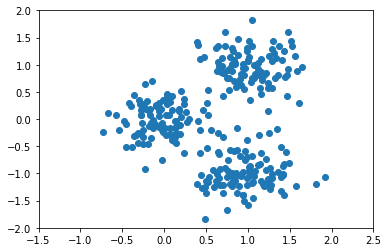

In [3]:
plt.scatter([x[0] for x in X],[x[1] for x in X])
plt.xlim([-1.5,2.5]),plt.ylim([-2,2])
plt.show()

Define kmeans algorithm that start from a random assignment of the points in k groups

In [35]:
def kmeans(X, num_clusters, max_iters=100, tolerance=1e-4, random_seed=None):
    num_samples = len(X)  # number of samples
    n = len(X[0])  # dimension of each vector
    distances = np.zeros(num_samples)  # stores distances of each point to nearest rep
    # point to the nearest representative.
    reps = [np.zeros(n)
            for j in range(num_clusters)]  # stores representatives
    progress = []  # used to visualize J updates
    
    # placeholder for ending condition: 
    # if previous J and current J haven't changed much, finish
    J_prev = np.Infinity
    
    # intializes a random assignment of num_samples integers between 0 and num_clusters
    random_state = np.random.RandomState(random_seed)
    assignment = [random_state.randint(num_clusters) for i in range(num_samples)]
    
    # start iteration
    for itr in range(max_iters):    
        # Cluster j representative is average of points in cluster j.
        for j in range(num_clusters):
            group = [i for i in range(num_samples) if assignment[i] == j]
            reps[j] = sum(X[group] / len(group))
        
        # For each X[i], find distance to the nearest representative 
        # and its group index.
        for i in range(num_samples):
            #(distance and index):
            (distances[i], assignment[i]) = (
                np.amin(
                    [np.linalg.norm(X[i] - reps[j]) for j in range(num_clusters)]
                ), 
                [np.linalg.norm(X[i] - reps[j]) for j in range(n_clusters)].index(
                    np.amin([np.linalg.norm(X[i] - reps[j]) for j in range(num_clusters)])
                )
            )
        J = (np.linalg.norm(distances)**2) / num_samples  # calculate objective
        
        progress.append([J, itr])
        print("Iteration " + str(itr) + ": Jclust = " + str(J) + ".")
        
        # check whether the stop condition is met
        if (itr > 1) and (abs(J - J_prev) < (tolerance * J)):
            return assignment, reps, progress
        J_prev = J
        
    return assignment, reps, progress

Iteration 0: Jclust = 0.9183587483209705.
Iteration 1: Jclust = 0.284033640864581.
Iteration 2: Jclust = 0.18295344307209171.
Iteration 3: Jclust = 0.17946700754613387.
Iteration 4: Jclust = 0.17942694791406946.
Iteration 5: Jclust = 0.17942694791406946.


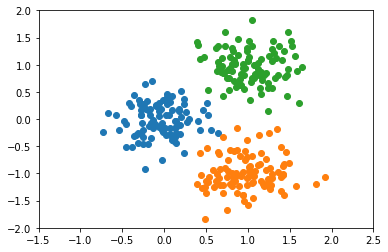

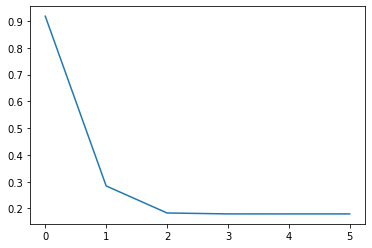

In [52]:
n_clusters = 3
assignment, reps, progress = kmeans(X, n_clusters)
groups = [[X[i] for i in range(len(X)) if assignment[i] == j] for j in range(n_clusters)]
plt.scatter([c[0] for c in groups[0]], [c[1] for c in groups[0]])
plt.scatter([c[0] for c in groups[1]], [c[1] for c in groups[1]])
plt.scatter([c[0] for c in groups[2]], [c[1] for c in groups[2]])
plt.xlim([-1.5,2.5])
plt.ylim([-2,2])
plt.show()

plt.plot([p[0] for p in progress])
plt.show()

Define kmeans algorithm that start from a random initial choice of representatives

In [75]:
def kmeans(X, num_clusters, max_iters=100, tolerance=1e-4, random_seed=None):
    
    num_samples = len(X)
    distances = np.zeros(num_samples)  # stores distances of each point to nearest rep
    assignment = np.zeros(num_samples)
    
    progress = []  # used to visualize J updates
    
    # placeholder for ending condition: 
    # if previous J and current J haven't changed much, finish
    J_prev = np.Infinity
    
    # initialize random centroids (i.e. representatives)
    random_state = np.random.RandomState(random_seed)
    seeds = random_state.permutation(num_samples)[:num_clusters]
    reps = X[seeds]
    
    # start iteration
    for itr in range(max_iters):
        
        # group assignment
        for i in range(num_samples):
            #(distance and index):
            (distances[i], assignment[i]) = (
                np.amin(
                    [np.linalg.norm(X[i] - reps[j]) for j in range(num_clusters)]
                ), 
                [np.linalg.norm(X[i] - reps[j]) for j in range(n_clusters)].index(
                    np.amin([np.linalg.norm(X[i] - reps[j]) for j in range(num_clusters)])
                )
            )
        J = (np.linalg.norm(distances)**2) / num_samples  # calculate objective
        
        # show info
        progress.append([J, itr])
        print("Iteration " + str(itr) + ": Jclust = " + str(J) + ".")
        
        # check whether the stop condition is met
        if (itr > 1) and (abs(J - J_prev) < (tolerance * J)):
            return assignment, reps, progress
        J_prev = J
        
        
        # Update centroid
        for j in range(num_clusters):
            group = [i for i in range(num_samples) if assignment[i] == j]
            reps[j] = sum(X[group] / len(group))
        
    return assignment, reps, progress

Iteration 0: Jclust = 1.1720616295284296.
Iteration 1: Jclust = 0.5400485793977498.
Iteration 2: Jclust = 0.4846760605875834.
Iteration 3: Jclust = 0.47061983345146285.
Iteration 4: Jclust = 0.4353557311975349.
Iteration 5: Jclust = 0.3425359924212493.
Iteration 6: Jclust = 0.20143480647173675.
Iteration 7: Jclust = 0.18007396082208083.
Iteration 8: Jclust = 0.17942694791406946.
Iteration 9: Jclust = 0.17942694791406946.


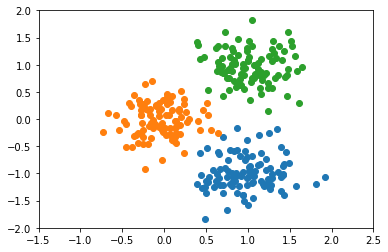

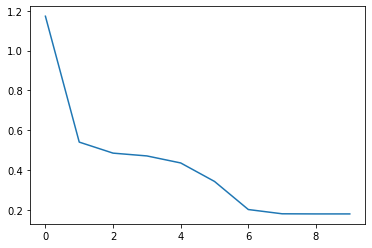

In [76]:
n_clusters = 3
assignment, reps, progress = kmeans(X, n_clusters)
groups = [[X[i] for i in range(len(X)) if assignment[i] == j] for j in range(n_clusters)]
plt.scatter([c[0] for c in groups[0]], [c[1] for c in groups[0]])
plt.scatter([c[0] for c in groups[1]], [c[1] for c in groups[1]])
plt.scatter([c[0] for c in groups[2]], [c[1] for c in groups[2]])
plt.xlim([-1.5,2.5])
plt.ylim([-2,2])
plt.show()

plt.plot([p[0] for p in progress])
plt.show()

Use sklearn's kmeans

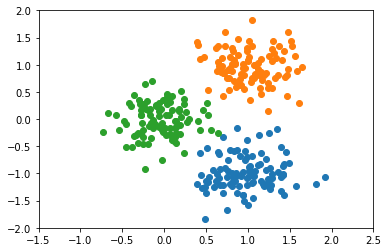

In [77]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
labels = kmeans.labels_
group_representative = kmeans.cluster_centers_
J_clust = kmeans.inertia_
grps = [[X[i,:] for i in range(300) if labels[i]==j] for j in range(3)]
plt.scatter([c[0] for c in grps[0]], [c[1] for c in grps[0]])
plt.scatter([c[0] for c in grps[1]], [c[1] for c in grps[1]])
plt.scatter([c[0] for c in grps[2]], [c[1] for c in grps[2]])
plt.xlim(-1.5, 2.5)
plt.ylim(-2,2)
plt.show()